In [1]:
import opensees.openseespy as ops
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# --- Units: inches, pounds (in, lb) ---

# --- Model setup ---
model = ops.Model('basic', ndm=2, ndf=3)  # 2D model

# --- Define nodes ---
node_data = {
    1: (0, 0),
    2: (0, 354),
    3: (118, 512),
    4: (276, 709),
    5: (-118, 512),
    6: (-276, 709),
    7: (-118, 709),
    8: (118, 709)
}

for node_tag, (x, y) in node_data.items():
    model.node(node_tag, x, y)

# --- Boundary conditions ---
model.fix(1, 1, 1, 1)  # Base fixed

# --- Materials and Sections ---
E = 29000.0  # ksi (steel) => 29000 ksi = 29,000,000 psi
E = E * 1000  # Convert to psi

# Section 1 (Big Tree Cylinder - stronger)
A1  = 779.0    # in²
Iz1 = 47712.0  # in⁴

# Section 2 (Small Tree Cylinder - lighter)
A2  =  195.0   # in²
Iz2 = 2944.0   # in⁴

# Define two sections
model.section('Elastic', 1, E, A1, Iz1)
model.section('Elastic', 2, E, A2, Iz2)

# --- Geometric transformation ---
model.geomTransf('Linear', 1)

# --- Beam Integration ---
model.beamIntegration('Lobatto', 1, 1, 5)  # (tag, sectionTag, nIP)
model.beamIntegration('Lobatto', 2, 2, 5)

# --- Define Elements ---
# Elements between nodes:
# Columns
model.element('forceBeamColumn', 1, 1, 2, 1, 1)  # Base to mid-column (Section 1)

# Beams/Branches
model.element('forceBeamColumn', 2, 2, 3, 1, 2)  # Mid to right branch
model.element('forceBeamColumn', 3, 2, 5, 1, 2)  # Mid to left branch

# Top horizontal connections
model.element('forceBeamColumn', 4, 3, 4, 1, 2)  
model.element('forceBeamColumn', 5, 3, 8, 1, 2)  
model.element('forceBeamColumn', 6, 5, 6, 1, 2)  
model.element('forceBeamColumn', 7, 5, 7, 1, 2)  

# --- Loads ---
model.timeSeries('Linear', 1)
model.pattern('Plain', 1, 1)

# Apply vertical load on top nodes
P = -100*1000.0  # lb (downward)
model.load(4, 0.0, P, 0.0, pattern=1)
model.load(6, 0.0, P, 0.0, pattern=1)
model.load(7, 0.0, P, 0.0, pattern=1)
model.load(8, 0.0, P, 0.0, pattern=1)



Node Displacements:
Node 1: Ux = 0.000000 in, Uy = 0.000000 in, Rz = 0.000000 rad
Node 2: Ux = 0.000000 in, Uy = -0.006268 in, Rz = -0.000000 rad
Node 3: Ux = 5.750645 in, Uy = -4.308028 in, Rz = -0.063750 rad
Node 4: Ux = 21.376155 in, Uy = -16.844628 in, Rz = -0.087117 rad
Node 5: Ux = -5.750645 in, Uy = -4.308028 in, Rz = 0.063750 rad
Node 6: Ux = -21.376155 in, Uy = -16.844628 in, Rz = 0.087117 rad
Node 7: Ux = -18.309420 in, Uy = -4.311511 in, Rz = 0.063750 rad
Node 8: Ux = 18.309420 in, Uy = -4.311511 in, Rz = -0.063750 rad


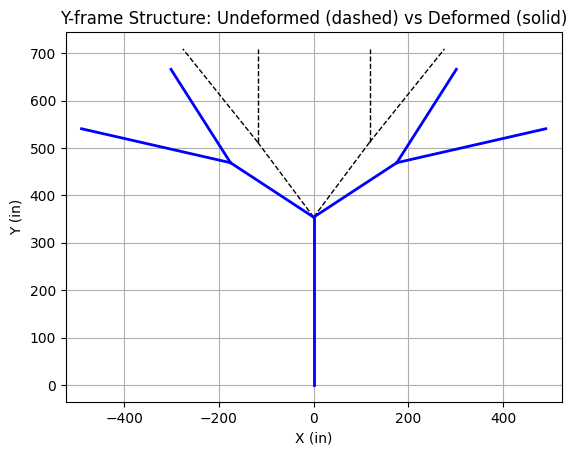

In [3]:
# --- Analysis setup ---
model.system('BandGeneral')
model.numberer('RCM')
model.constraints('Plain')
model.integrator('LoadControl', 1.0)
model.algorithm('Newton')
model.analysis('Static')

# Perform analysis
model.analyze(1)

# --- Post-processing ---
print("\nNode Displacements:")
for node in node_data.keys():
    disp = model.nodeDisp(node)
    print(f"Node {node}: Ux = {disp[0]:.6f} in, Uy = {disp[1]:.6f} in, Rz = {disp[2]:.6f} rad")

# --- Plot undeformed and deformed shape ---
scale = 10  # Magnify deformation for visibility
def plot_frame():
    fig, ax = plt.subplots()
    for ele in range(1, 8):
        nds = model.eleNodes(ele)
        x_orig = [node_data[nds[0]][0], node_data[nds[1]][0]]
        y_orig = [node_data[nds[0]][1], node_data[nds[1]][1]]
        x_def = [
            node_data[nds[0]][0] + scale * model.nodeDisp(nds[0], 1),
            node_data[nds[1]][0] + scale * model.nodeDisp(nds[1], 1)
        ]
        y_def = [
            node_data[nds[0]][1] + scale * model.nodeDisp(nds[0], 2),
            node_data[nds[1]][1] + scale * model.nodeDisp(nds[1], 2)
        ]
        ax.plot(x_orig, y_orig, 'k--', linewidth=1)  # Undeformed
        ax.plot(x_def, y_def, 'b-', linewidth=2)    # Deformed

    ax.set_xlabel('X (in)')
    ax.set_ylabel('Y (in)')
    ax.set_title('Y-frame Structure: Undeformed (dashed) vs Deformed (solid)')
    ax.axis('equal')
    plt.grid(True)
    plt.show()

plot_frame()
